# Importing Dependencies

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm
tqdm.pandas()
import tensorflow as tf
from tensorflow import keras

import nltk
import re


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_E6oV3lV.csv to train_E6oV3lV.csv


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/My Drive/train_E6oV3lV.csv')

let’s first take a look at the data.Dataset has 31962 entries, with no null entries..
where 29720 entries of the data with  label **0**(non-racist), and 2242 entries of the data with label 1 (racist).it clearly shows how our data is highly imbalanced.

In [4]:
data.head()

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

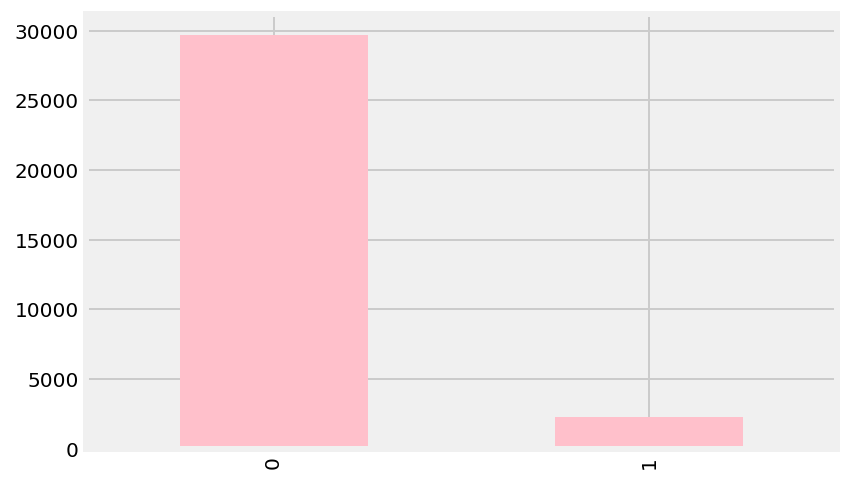

In [5]:
data['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

In [6]:
test = pd.read_csv('/content/drive/My Drive/test_tweets_anuFYb8.csv')

As a way of sanity check, let’s look at the length of the string in text column in each entry.

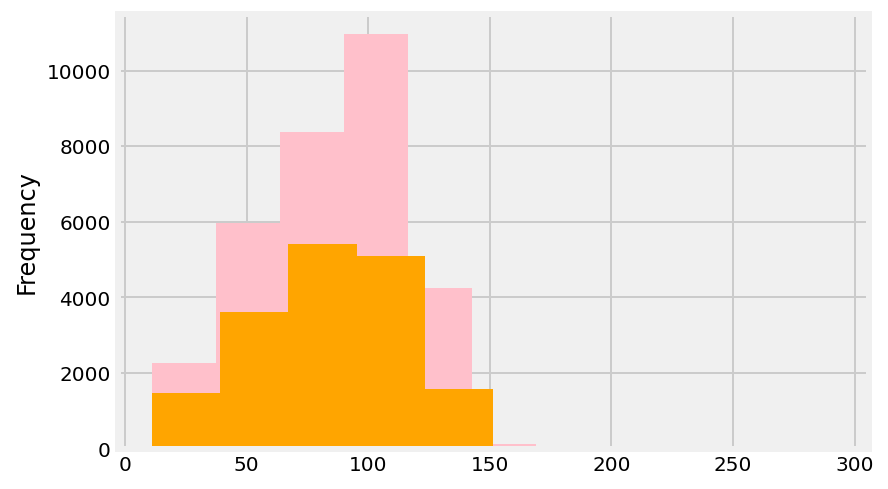

In [7]:
# checking the distribution of tweets in the data

length_train = data['tweet'].str.len().plot.hist(color = 'pink', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

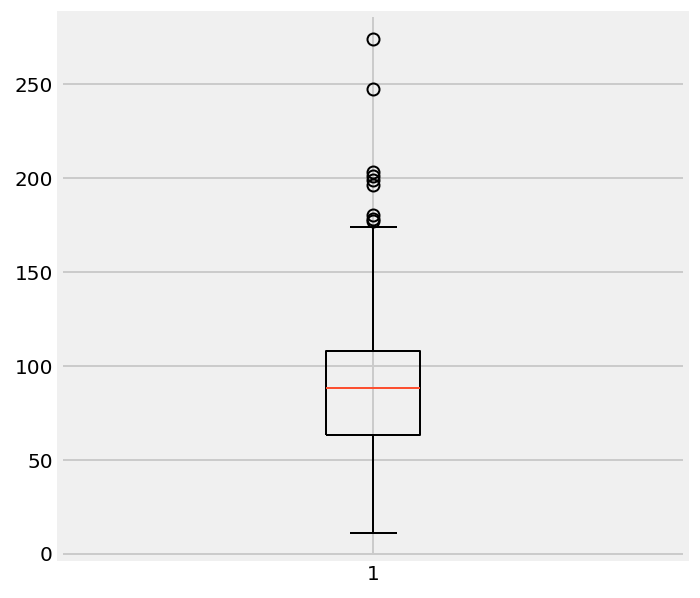

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.len)
plt.show()

This looks a bit strange, since the twitter’s character limit is 140. But from the above box plot, some of the tweets are way more than 140 characters long.It looks like it’s time for some cleaning!

In [11]:
data['len'] = data['tweet'].str.len()
test['len'] = test['tweet'].str.len()

data.head(10)

id  label                                              tweet  len
0   1      0   @user when a father is dysfunctional and is s...  102
1   2      0  @user @user thanks for #lyft credit i can't us...  122
2   3      0                                bihday your majesty   21
3   4      0  #model   i love u take with u all the time in ...   86
4   5      0             factsguide: society now    #motivation   39
5   6      0  [2/2] huge fan fare and big talking before the...  116
6   7      0   @user camping tomorrow @user @user @user @use...   74
7   8      0  the next school year is the year for exams.ð...  143
8   9      0  we won!!! love the land!!! #allin #cavs #champ...   87
9  10      0   @user @user welcome here !  i'm   it's so #gr...   50

In [12]:
data.groupby('label').describe()

id                                   ...   len                    
         count          mean          std   min  ...   25%   50%    75%    max
label                                            ...                          
0      29720.0  15974.454441  9223.783469   1.0  ...  62.0  88.0  107.0  274.0
1       2242.0  16074.896075  9267.955758  14.0  ...  69.0  96.0  111.0  152.0

[2 rows x 16 columns]

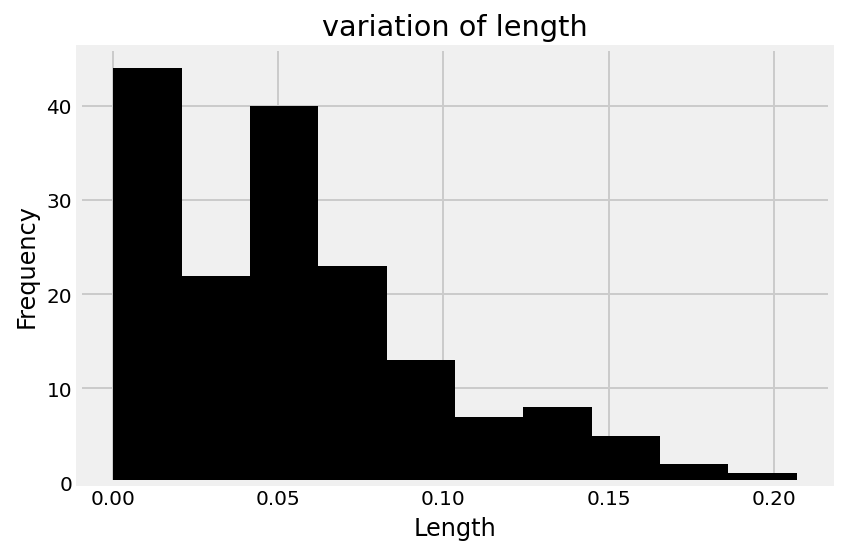

In [15]:
data.groupby('len').mean()['label'].plot.hist(color = 'black', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

In [20]:
# collecting the hashtags
import re
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [21]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(data['tweet'][data['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(data['tweet'][data['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


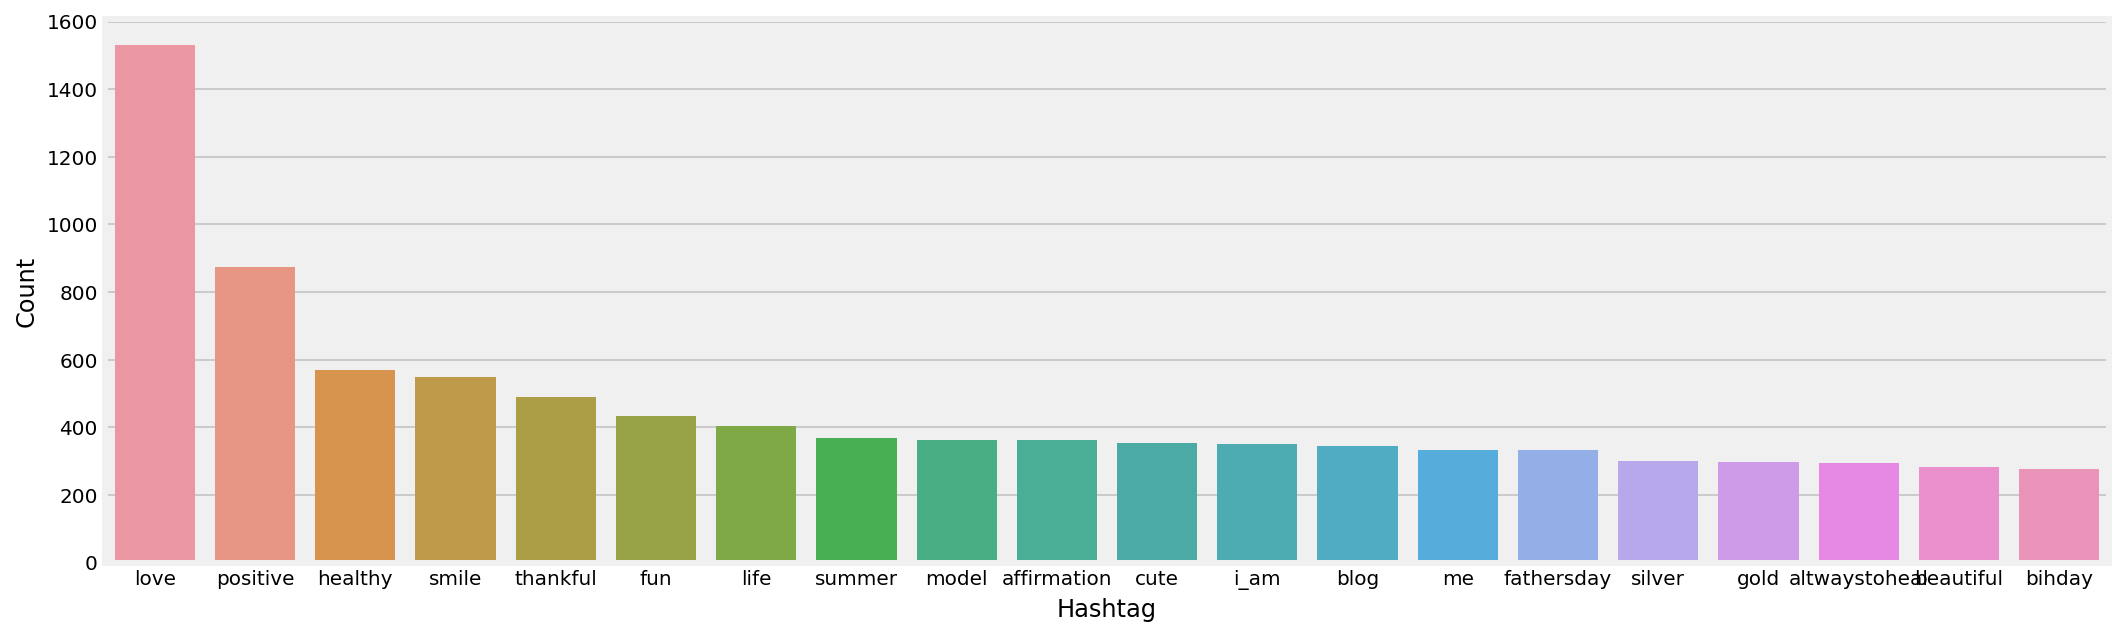

In [25]:
import seaborn as sns
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

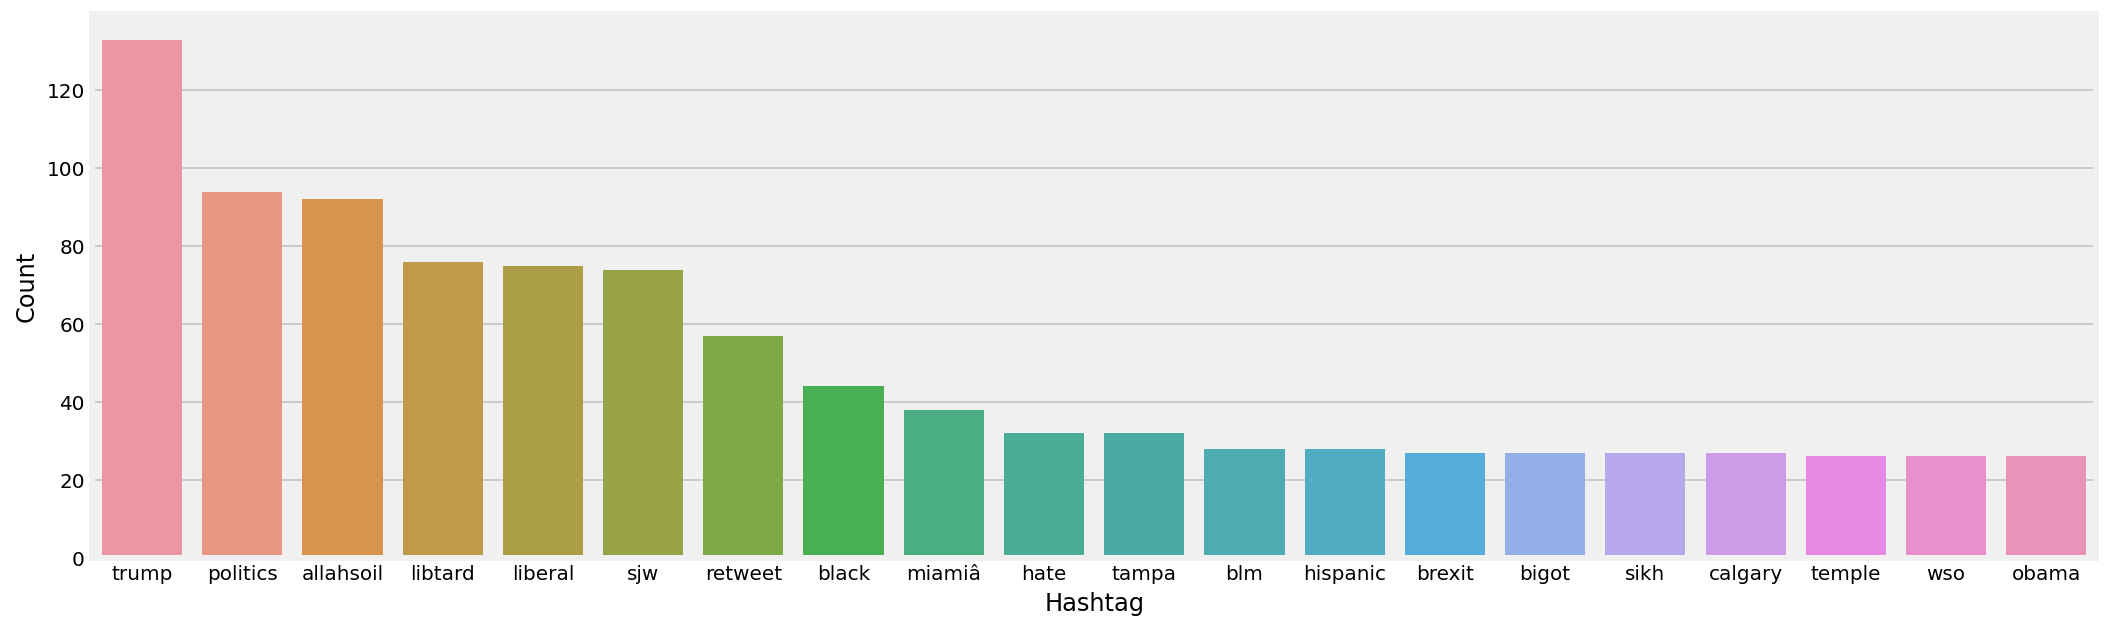

In [26]:

a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

I will first define data cleaning function, and then will be applied to the whole dataset. Tokenization, stemming/lemmatization, stop words will be dealt with later stage when creating matrix with either count vectorizer or Tfidf vectorizer.

The order of the cleaning is

Souping

BOM removing

url address(‘http:’pattern), twitter ID removing

url address(‘www.'pattern) removing

lower-case

negation handling

removing numbers and special characters

tokenizing and joining

In [27]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text,"lxml")
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [28]:
print ("Cleaning and parsing the tweets...\n")
clean_tweet_texts = data['tweet'].progress_apply(lambda x: tweet_cleaner(x)).values


  1%|          | 394/31962 [00:00<00:08, 3933.98it/s]

Cleaning and parsing the tweets...



100%|██████████| 31962/31962 [00:07<00:00, 4093.26it/s]


In [29]:
clean_tweet_texts

array(['when father is dysfunctional and is so selfish he drags his kids into his dysfunction run',
       'thanks for lyft credit can not use cause they do not offer wheelchair vans in pdx disapointed getthanked',
       'bihday your majesty', ...,
       'listening to sad songs on monday morning otw to work is sad',
       'sikh temple vandalised in in calgary wso condemns act',
       'thank you for you follow'], dtype=object)

In [30]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['label'] = data.label
clean_df.head()

text  label
0  when father is dysfunctional and is so selfish...      0
1  thanks for lyft credit can not use cause they ...      0
2                                bihday your majesty      0
3            model love take with all the time in ur      0
4                  factsguide society now motivation      0

There are parameter options available for count vectorizer, such as removing stop words, limiting the maximum number of terms. However, in order to get a full picture of the dataset first, I implemented with stop words included, and not limiting the maximum number of terms.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(clean_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [32]:
len(cvec.get_feature_names())

37524

OK, it looks like the count vectorizer has extracted 264,936 words out of the corpus.

Once you transform the data with the fitted count vectorizer, you can directly get the term frequency from the sparse matrix.

In [33]:
neg_doc_matrix = cvec.transform(clean_df[clean_df.label == 1].text)
pos_doc_matrix = cvec.transform(clean_df[clean_df.label == 0].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [34]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive  total
the       843      9396  10239
to        568      9300   9868
you       500      5452   5952
and       368      4579   4947
in        452      4253   4705
for       250      4262   4512
is        462      3846   4308
of        461      3801   4262
my         73      3645   3718
it        204      3441   3645

In [35]:
term_freq_df.tail()

negative  positive  total
zydeco           0         2      2
zz               0         1      1
zzz              0         1      1
zzzzzz           0         1      1
zzzzzzzz         0         2      2

# Zipf’s Law

Interesting fact is that “given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc."

Let’s see how the tweet tokens and their frequencies look like on a plot.

Text(0.5, 1.0, 'Top 500 tokens in tweets')

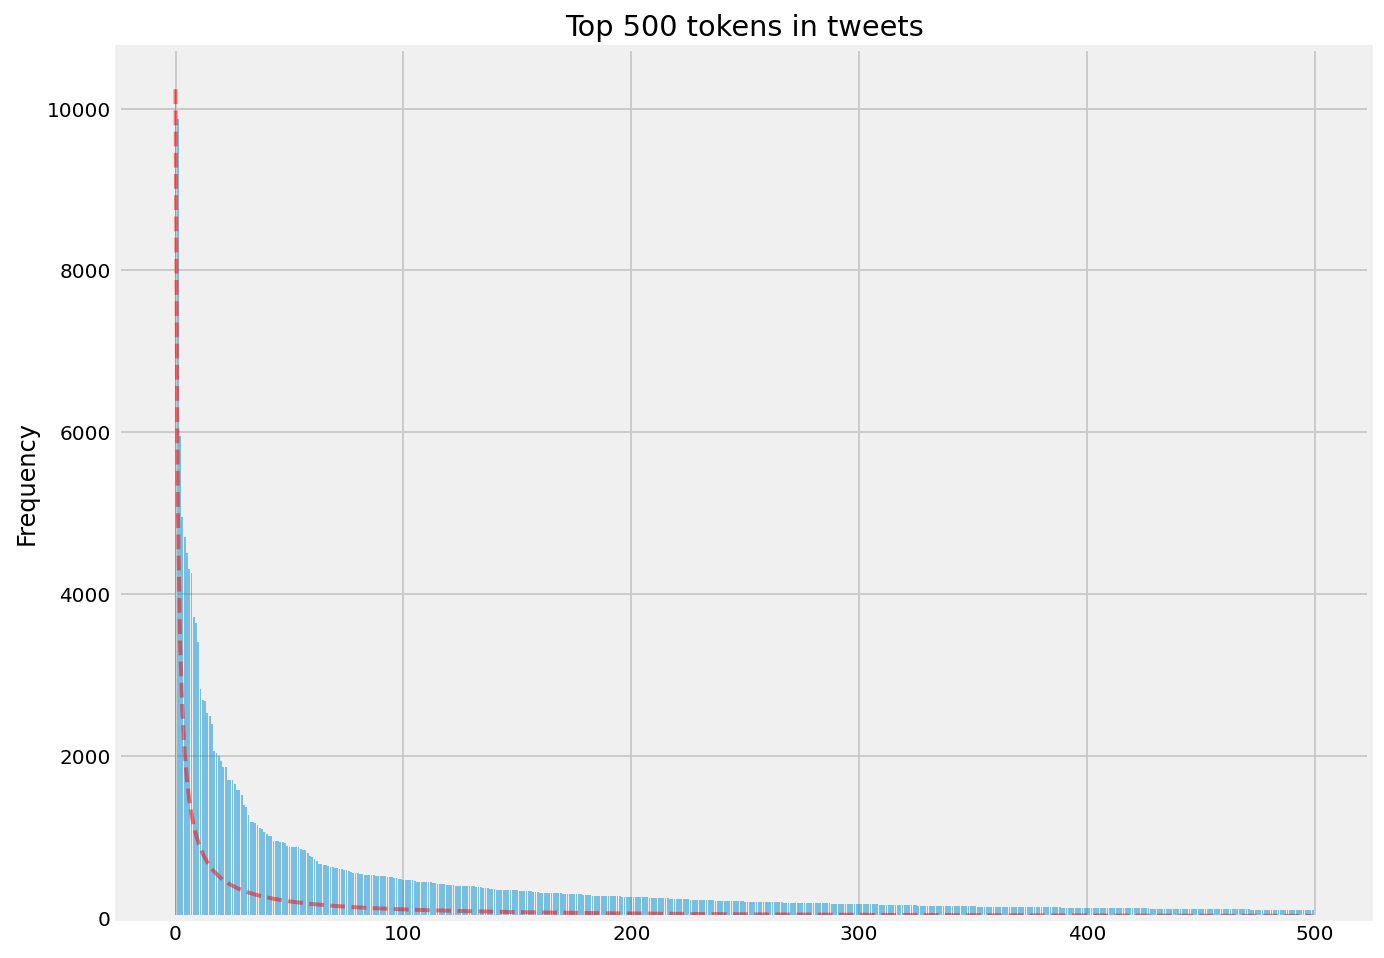

In [36]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

On the X-axis is the rank of the frequency from highest rank from left up to 500th rank to the right. Y-axis is the frequency observed in the corpus (in this case, “Sentiment140” dataset). One thing to note is that the actual observations in most cases does not strictly follow Zipf’s distribution, but rather follow a trend of “near-Zipfian” distribution.

Even though we can see the plot follows the trend of Zipf’s Law, but it looks like it has more area above the expected Zipf curve in higher ranked words.

Another way to plot this is on a log-log graph, with X-axis being log(rank), Y-axis being log(frequency). By plotting on a log-log scale the result will yield roughly linear line on the graph.

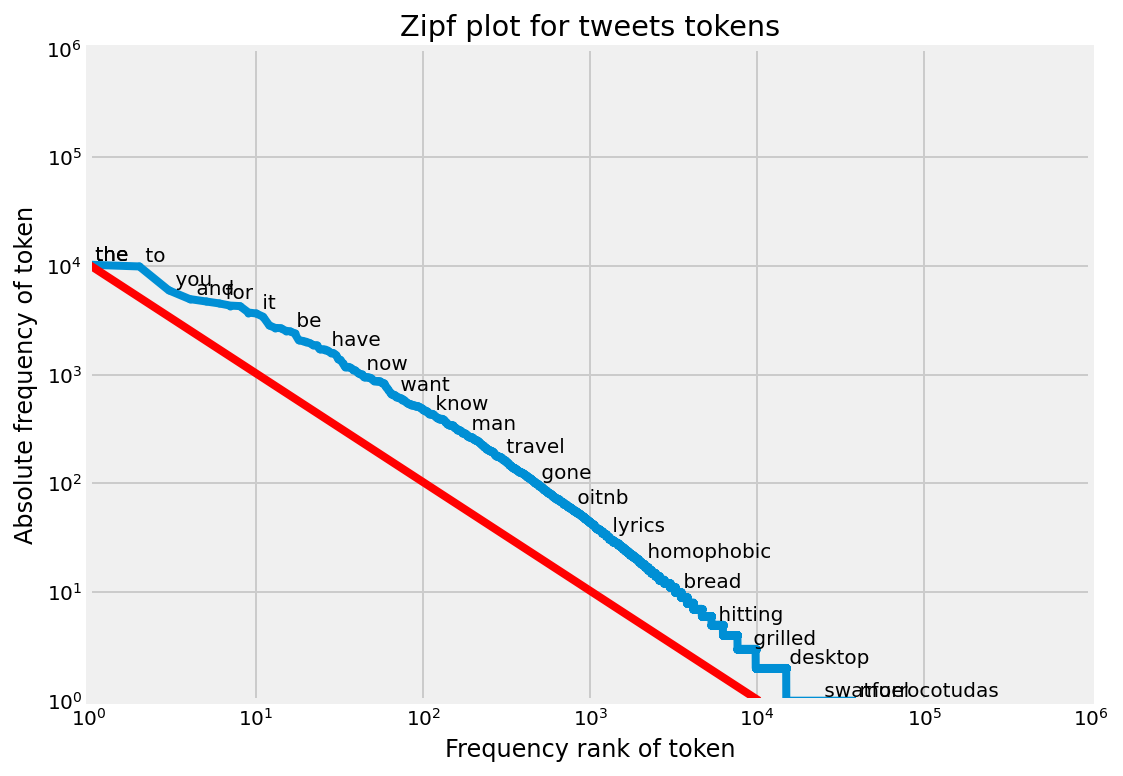

In [ ]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Again we see a roughly linear curve, but deviating above the expected line.

Let’s see what are the top 50 words in negative tweets on a bar chart.

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

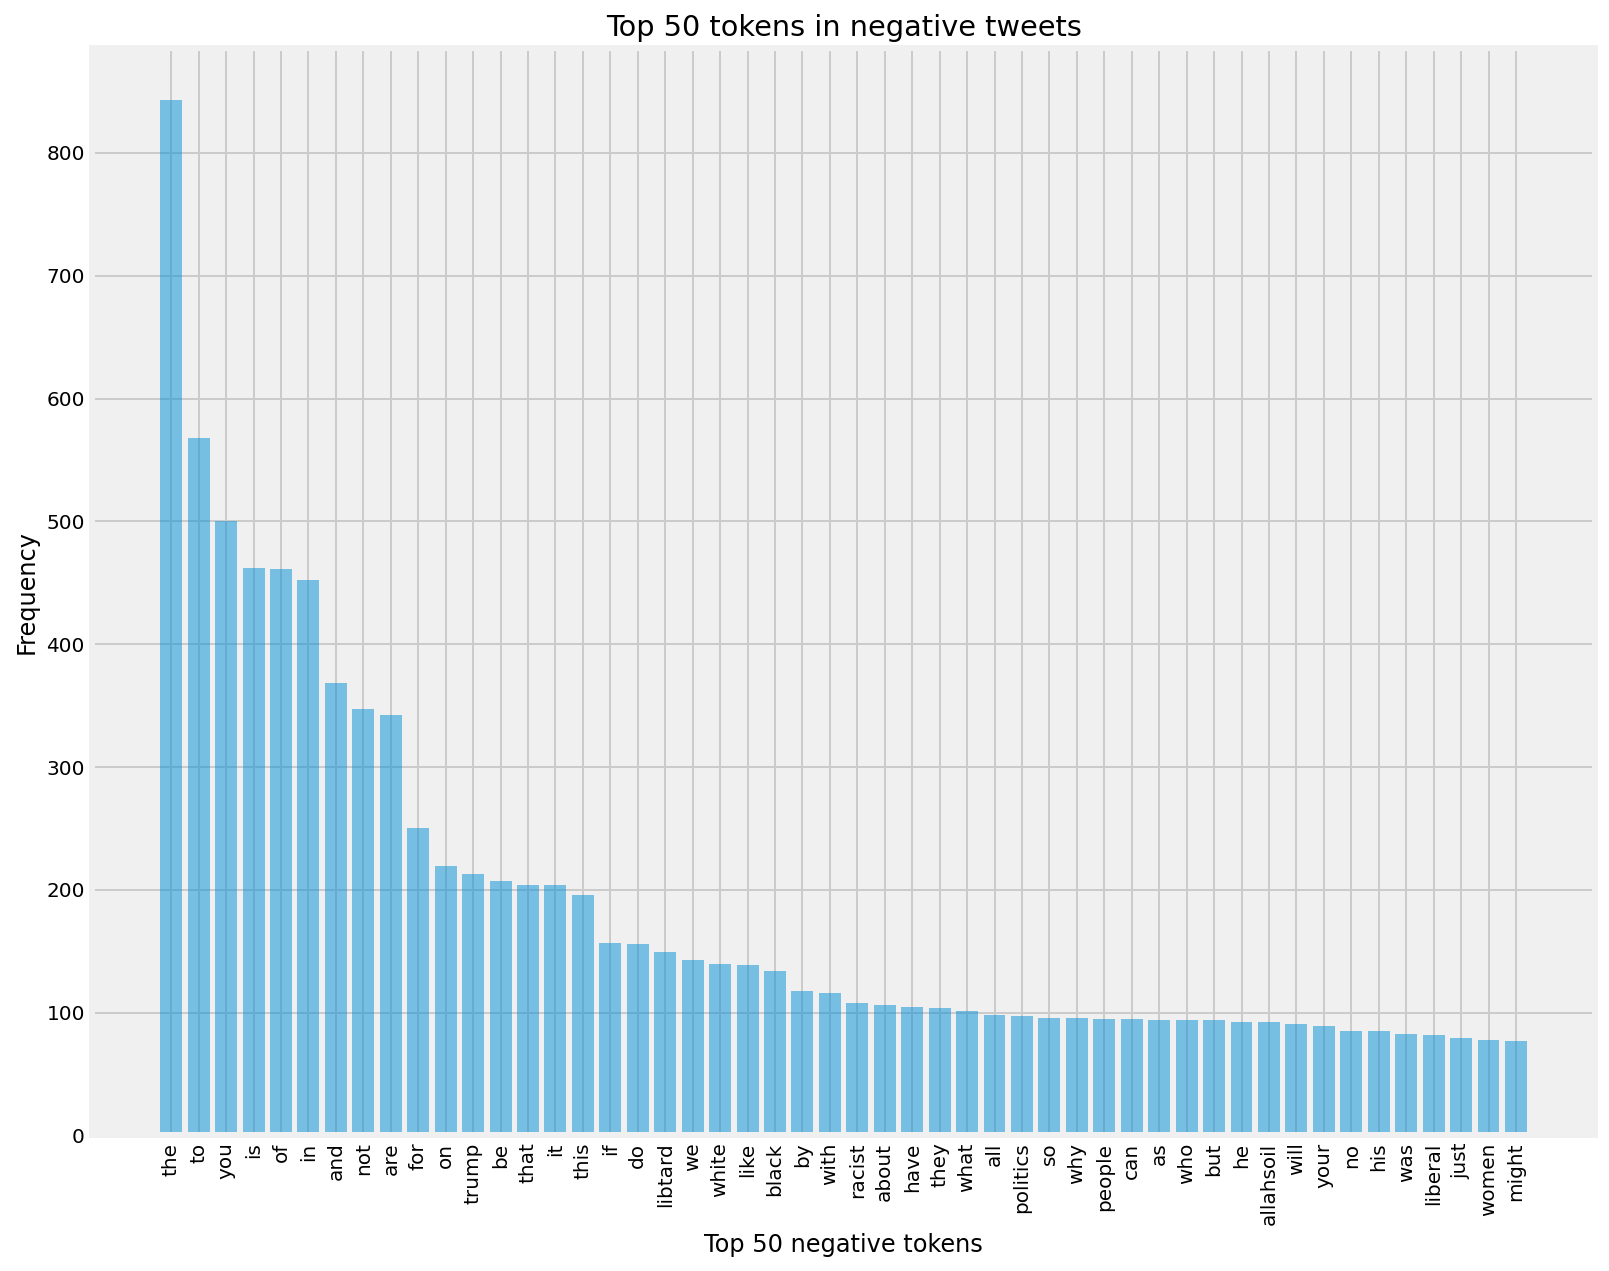

In [ ]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Even though some of the top 50 tokens can provide some information about the negative tweets, some neutral words such as “the”, “you”, are one of the most frequent tokens. Even though these are the actual high-frequency words, but it is difficult to say that these words are all important words in negative tweets that characterises the negative class.
Let’s also take a look at top 50 positive tokens on a bar chart.

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

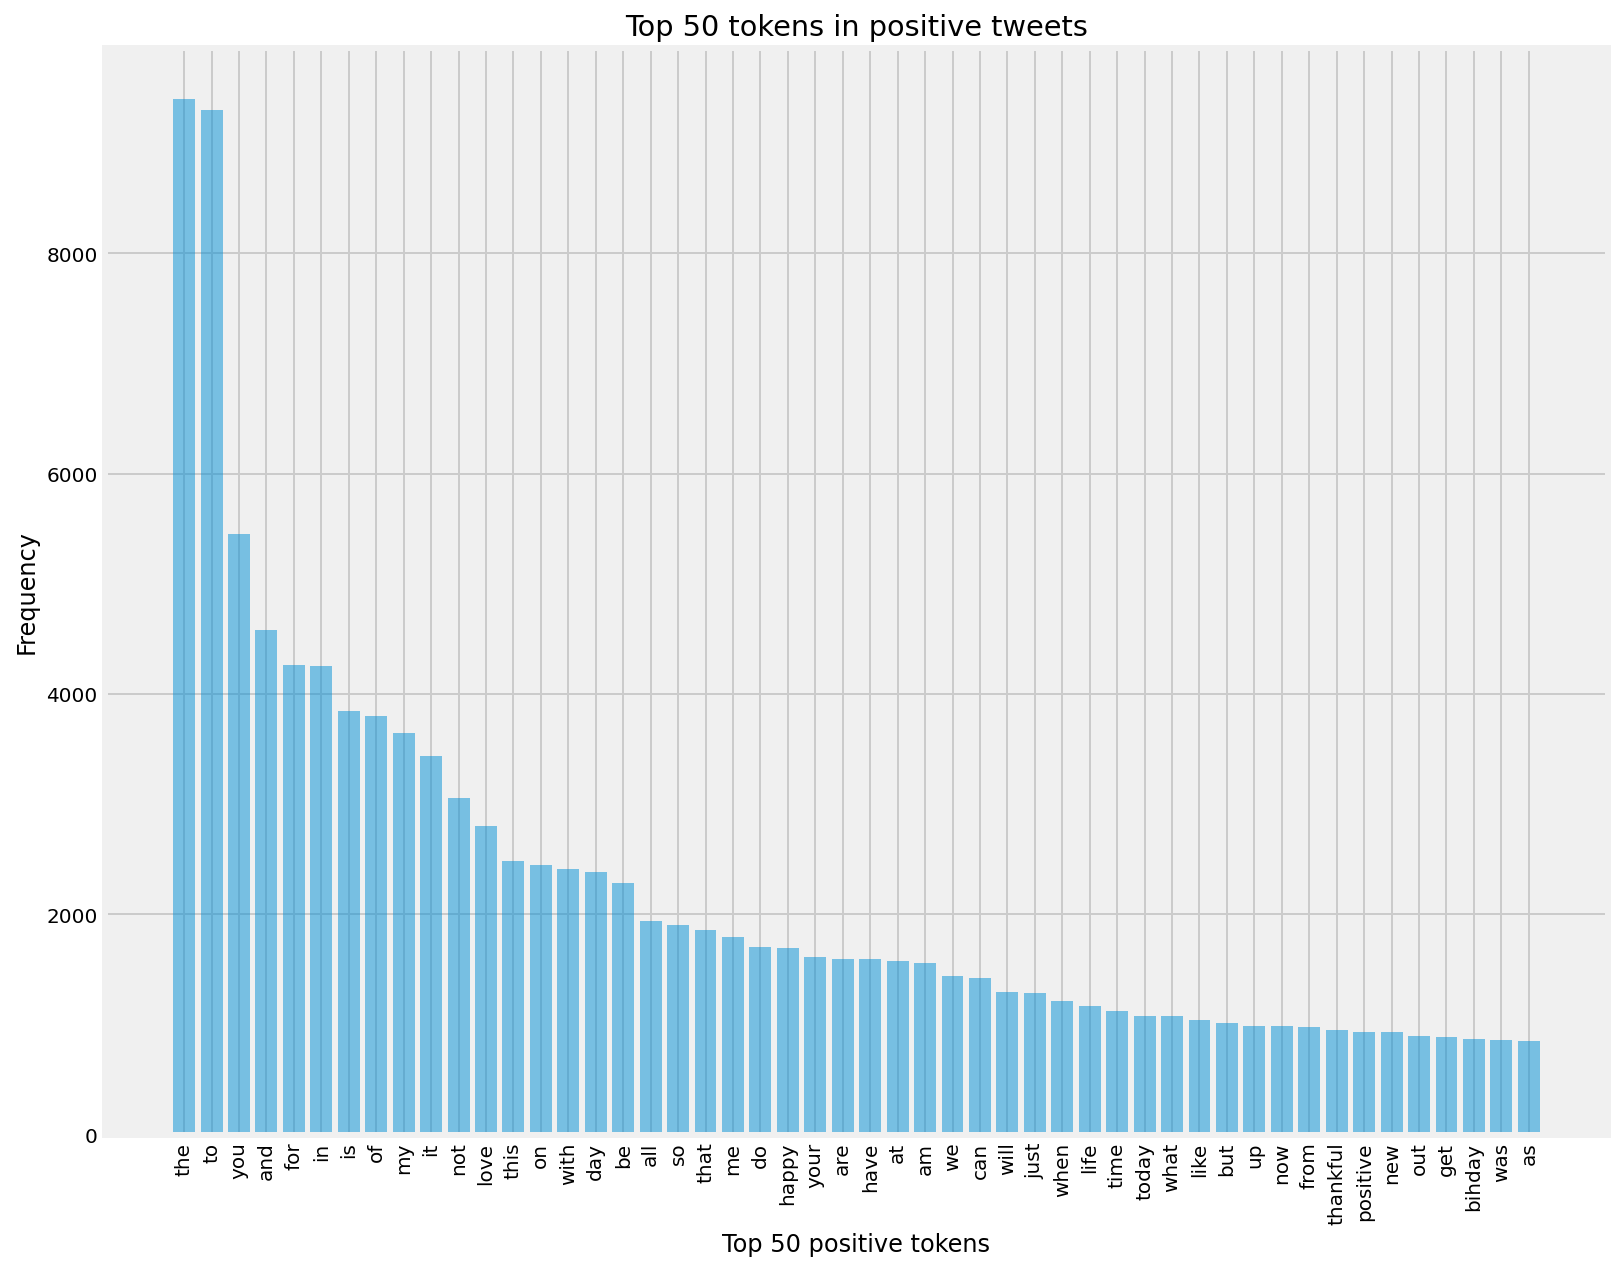

In [ ]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

What if we plot the negative frequency of a word on X-axis, and the positive frequency on Y-axis?

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

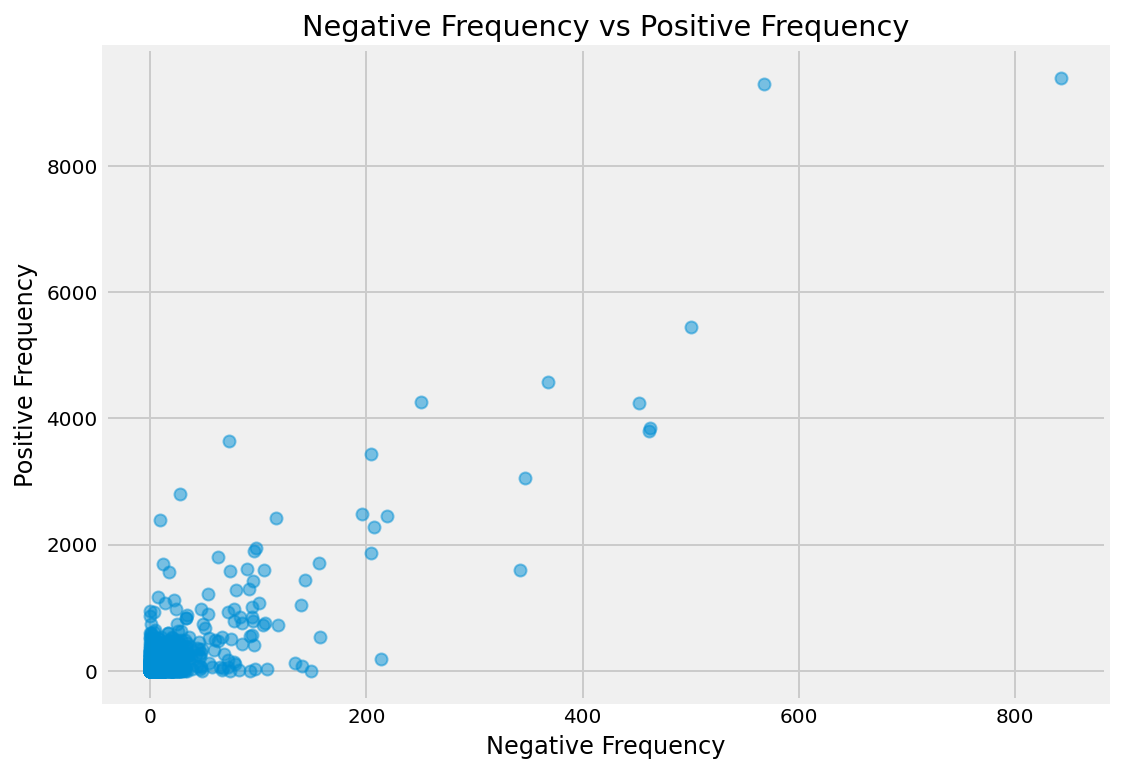

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

Most of the words are below 100 on X-axis and 1000 on Y-axis, and we cannot see meaningful relations between negative and positive frequency.

let’s explore what we can get out of frequency of each token. Intuitively, if a word appears more often in one class compared to another, this can be a good measure of how much the word is meaningful to characterise the class. In the below code I named it as ‘pos_rate'.

In [ ]:
term_freq_df['pos_rate'] = term_freq_df['positive'] * 1./term_freq_df['total']
term_freq_df.sort_values(by='pos_rate', ascending=False).iloc[:10]

negative  positive  total  pos_rate
aa                      0         2      2       1.0
oriental                0         1      1       1.0
orlan                   0         1      1       1.0
orla                    0         2      2       1.0
ork                     0         3      3       1.0
orillia                 0         1      1       1.0
origins                 0         2      2       1.0
originalsong            0         2      2       1.0
originalmusic           0         1      1       1.0
originalcontent         0         1      1       1.0

Words with highest pos_rate have zero frequency in the negative tweets, but overall frequency of these words are too low to consider it as a guideline for positive tweets.

Another metric is the frequency a word occurs in the class.But since pos_freq_pct is just the frequency scaled over the total sum of the frequency, the rank of pos_freq_pct is exactly same as just the positive frequency.

What we can do now is to combine pos_rate, pos_freq_pct together to come up with a metric which reflects both pos_rate and pos_freq_pct. Even though both of these can take a value ranging from 0 to 1, pos_rate has much wider range actually spanning from 0 to 1, while all the pos_freq_pct values are squashed within the range smaller than 0.015. If we average these two numbers, pos_rate will be too dominant, and will not reflect both metrics effectively.so lets use haronic mean.

In [ ]:
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] * 1./term_freq_df['positive'].sum()
term_freq_df.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct
the       843      9396  10239  0.917668      0.027280
to        568      9300   9868  0.942440      0.027001
you       500      5452   5952  0.915995      0.015829
and       368      4579   4947  0.925611      0.013294
for       250      4262   4512  0.944592      0.012374
in        452      4253   4705  0.903932      0.012348
is        462      3846   4308  0.892758      0.011166
of        461      3801   4262  0.891835      0.011036
my         73      3645   3718  0.980366      0.010583
it        204      3441   3645  0.944033      0.009990

In [ ]:
from scipy.stats import hmean
term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])                                                               if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct  pos_hmean
the       843      9396  10239  0.917668      0.027280   0.052985
to        568      9300   9868  0.942440      0.027001   0.052498
you       500      5452   5952  0.915995      0.015829   0.031120
and       368      4579   4947  0.925611      0.013294   0.026212
for       250      4262   4512  0.944592      0.012374   0.024428
in        452      4253   4705  0.903932      0.012348   0.024363
is        462      3846   4308  0.892758      0.011166   0.022057
of        461      3801   4262  0.891835      0.011036   0.021801
my         73      3645   3718  0.980366      0.010583   0.020939
it        204      3441   3645  0.944033      0.009990   0.019772

What we can try next is to get the CDF (Cumulative Distribution Function) value of both pos_rate and pos_freq_pct.we calculate a harmonic mean of these two CDF values, as we did earlier. By calculating the harmonic mean, we can see that pos_normcdf_hmean metric provides a more meaningful measure of how important a word is within the class.

In [ ]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])
term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
term_freq_df.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]


negative  positive  ...  pos_freq_pct_normcdf  pos_normcdf_hmean
thankful            0       952  ...              1.000000           0.771541
bihday              0       874  ...              1.000000           0.771541
weekend             0       604  ...              1.000000           0.771541
friday              0       531  ...              0.999999           0.771541
bull                0       504  ...              0.999996           0.771540
tomorrow            0       446  ...              0.999964           0.771530
happiness           0       398  ...              0.999793           0.771479
affirmation         0       364  ...              0.999364           0.771352
amazing             0       332  ...              0.998314           0.771039
gold                0       319  ...              0.997550           0.770811

[10 rows x 9 columns]

In [ ]:
term_freq_df['neg_rate'] = term_freq_df['negative'] * 1./term_freq_df['total']
term_freq_df['neg_freq_pct'] = term_freq_df['negative'] * 1./term_freq_df['negative'].sum()
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df['neg_rate_normcdf'] = normcdf(term_freq_df['neg_rate'])
term_freq_df['neg_freq_pct_normcdf'] = normcdf(term_freq_df['neg_freq_pct'])
term_freq_df['neg_normcdf_hmean'] = hmean([term_freq_df['neg_rate_normcdf'], term_freq_df['neg_freq_pct_normcdf']])
term_freq_df.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

negative  positive  ...  neg_freq_pct_normcdf  neg_normcdf_hmean
allahsoil        92         0  ...              1.000000           0.999966
sjw              74         0  ...              1.000000           0.999966
libtard         149         3  ...              1.000000           0.999953
stomping         48         2  ...              1.000000           0.999934
blm              34         3  ...              0.999817           0.999782
racism           66        10  ...              1.000000           0.999730
tampa            32         4  ...              0.999596           0.999598
liberal          82        17  ...              1.000000           0.999520
hispanic         29         1  ...              0.998770           0.999325
bigot            29         2  ...              0.998770           0.999287

[10 rows x 15 columns]

Now let’s see how the values are converted into a plot. In order to compare, I will first plot neg_hmean vs pos_hmean, and neg_normcdf_hmean vs pos_normcdf_hmean.

Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

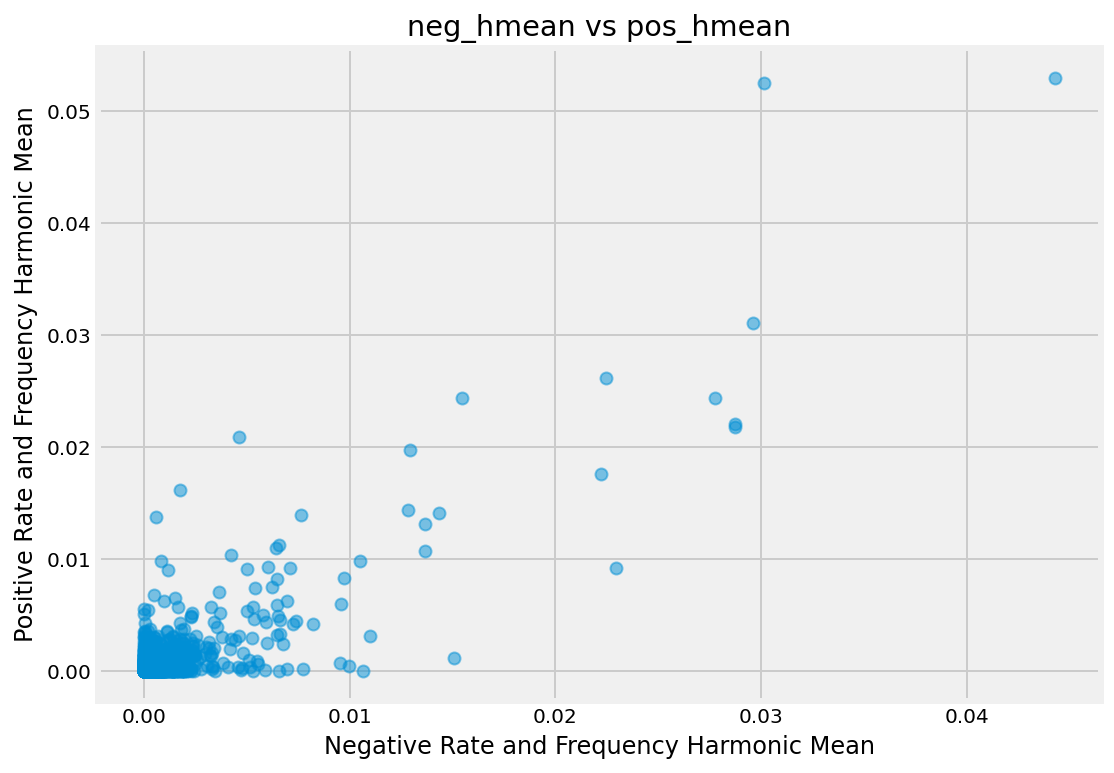

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Not much difference from the just frequency of positive and negative. How about the CDF harmonic mean?

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

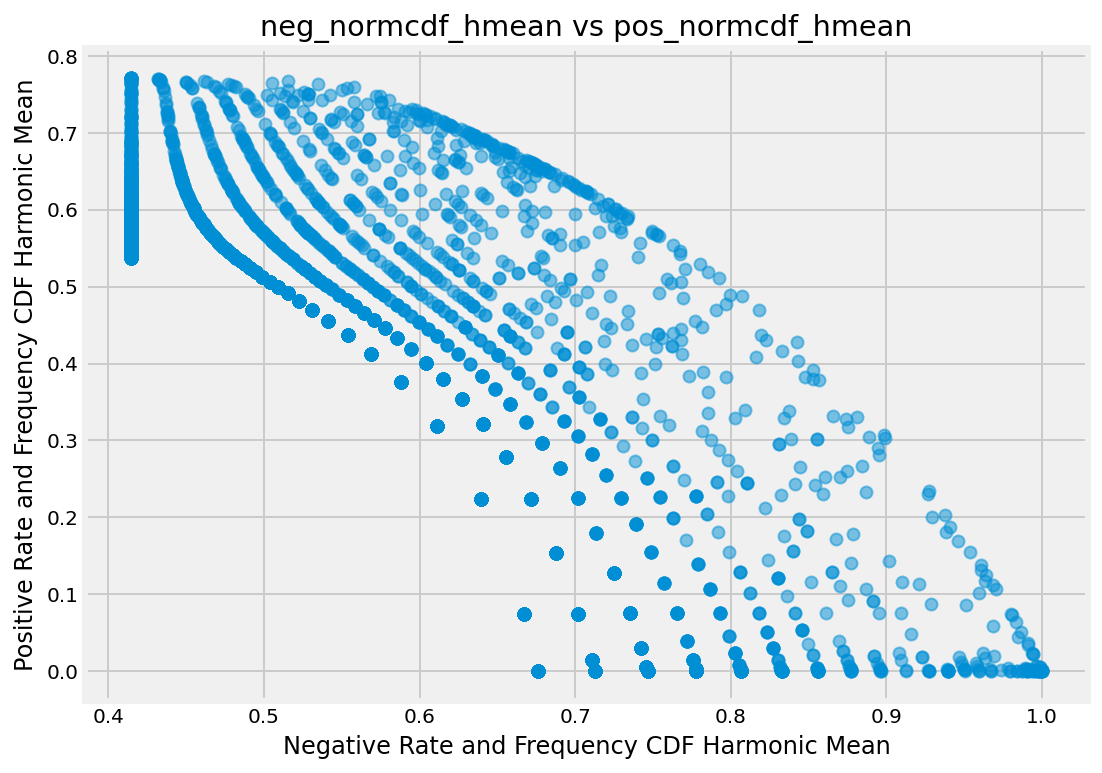

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

It seems like the harmonic mean of rate CDF and frequency CDF has created an interesting pattern on the plot. If a data point is near to the upper left corner, it is more positive, and if it is closer to the bottom right corner, it is more negative.
So I took an alternative method of an interactive plot with Bokeh. Bokeh is an interactive visualisation library for Python, which creates graphics in style of D3.js.

In [ ]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df.pos_normcdf_hmean), high=max(term_freq_df.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

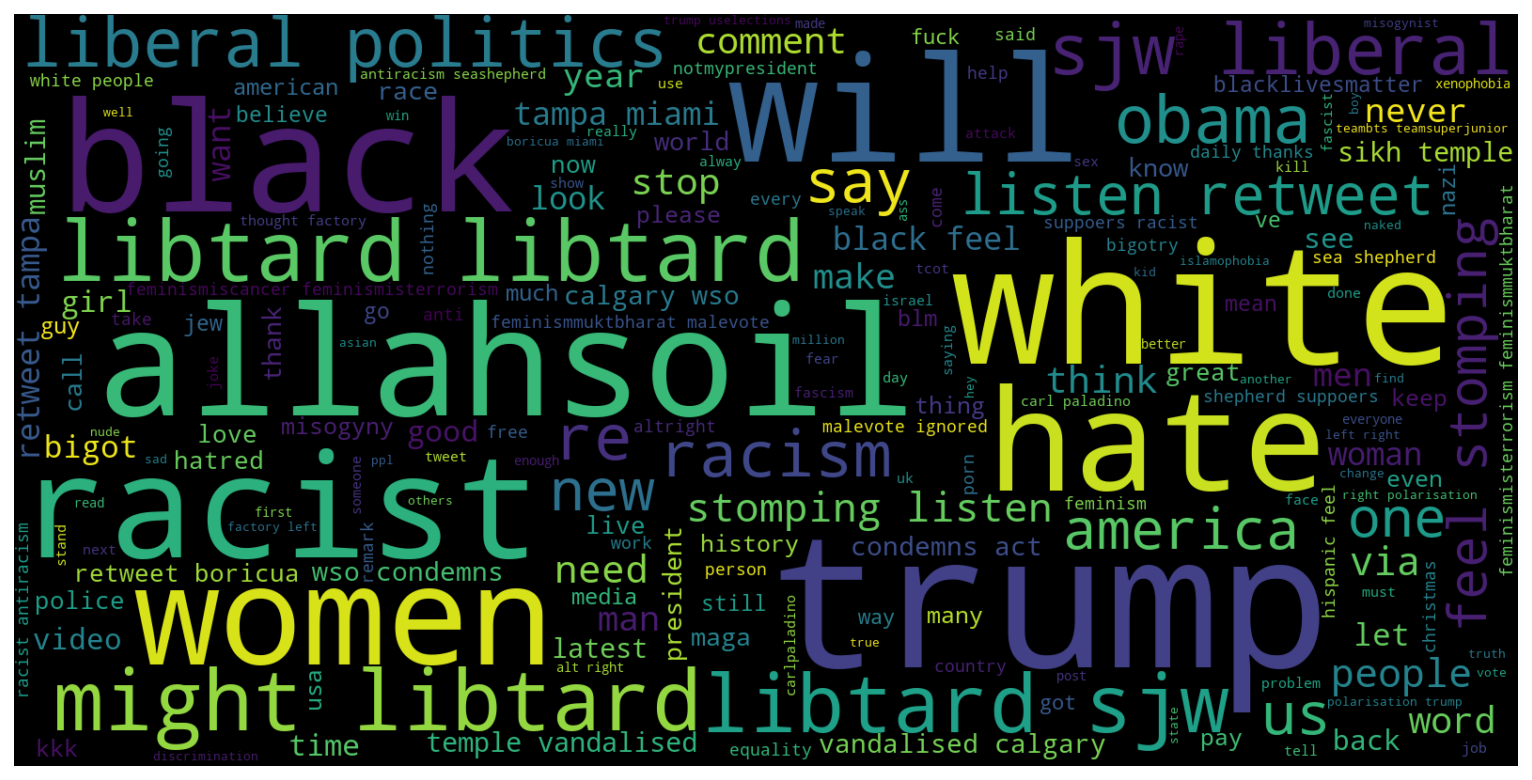

In [39]:
from wordcloud import WordCloud

neg_tweets = clean_df[clean_df.label == 1]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

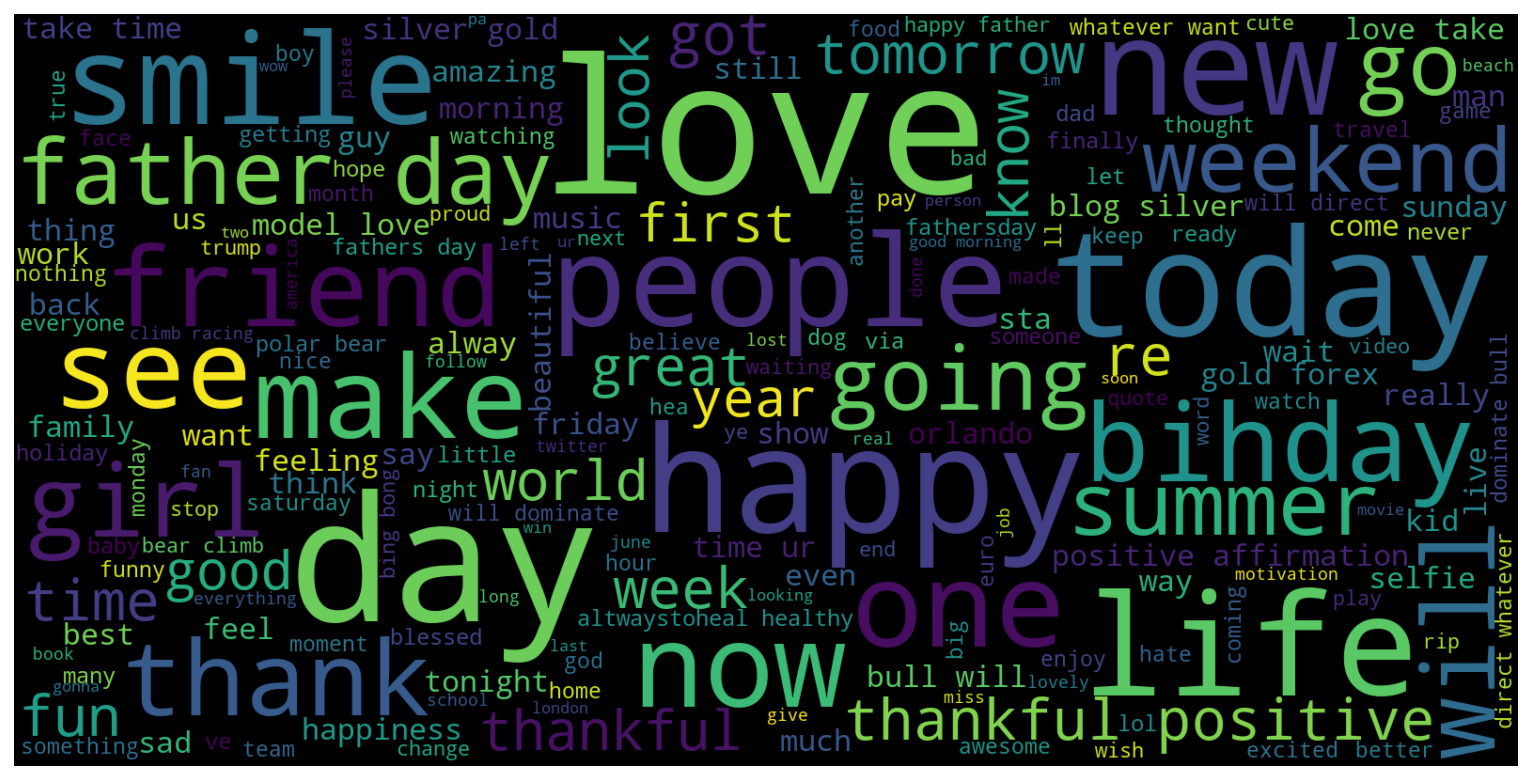

In [38]:
from wordcloud import WordCloud

neg_tweets = clean_df[clean_df.label == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Imbalced learning
As I have already realised, the training data is not perfectly balanced

The simple default classifier I’ll use to compare performances of different datasets will be the logistic regression. From my previous sentiment analysis project, I learned that Tf-Idf with Logistic Regression is a pretty powerful combination. Before I apply any other more complex models such as ANN, CNN, RNN etc, the performances with logistic regression will hopefully give me a good idea of which data sampling methods I should choose.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              negative    positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [99]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
train_samples= cv.fit_transform(train_samples).toarray()
val_samples= cv.fit_transform(val_samples).toarray()

print(x.shape)
print(y.shape)

(121414, 2500)
(121414,)


In [100]:
model = LogisticRegression()
model.fit(train_samples, train_labels)

y_pred = model.predict(val_samples)

print("Training Accuracy :", model.score(train_samples, train_labels))
print("Validation Accuracy :", model.score(val_samples, val_labels))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(val_labels, y_pred))

# confusion matrix
cm = confusion_matrix(val_labels, y_pred)
print(cm)

Training Accuracy : 0.9675445969926216
Validation Accuracy : 0.8973265073947668
f1 score : 0.06395851339671564


NameError: ignored

In [41]:
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])
lr_cv(5, clean_df.text, clean_df.label, original_pipeline, 'macro')

              negative    positive
precision: [0.94448863 0.94339623]
recall:    [0.99899058 0.22271715]
f1 score:  [0.97097539 0.36036036]
--------------------------------------------------
              negative    positive
precision: [0.94652833 0.890625  ]
recall:    [0.99764468 0.25389755]
f1 score:  [0.97141453 0.39514731]
--------------------------------------------------
              negative    positive
precision: [0.94585125 0.95575221]
recall:    [0.99915882 0.24107143]
f1 score:  [0.97177452 0.38502674]
--------------------------------------------------
              negative    positive
precision: [0.94703255 0.93548387]
recall:    [0.9986541  0.25892857]
f1 score:  [0.97215853 0.40559441]
--------------------------------------------------
              negative    positive
precision: [0.94473642 0.89380531]
recall:    [0.99798116 0.22544643]
f1 score:  [0.97062914 0.3600713 ]
--------------------------------------------------
accuracy: 94.53% (+/- 0.11%)
precision: 93.48

With data as it is without any resampling, we can see that the precision is higher than the recall.

This means the classifier is very picky and does not think many things are negative. All the text it classifies as negative is 61~65% of the time really negative. However, it also misses a lot of actual negative class, because it is so very picky. We have a low recall, but a very high precision.

# SMOTE (Synthetic Minority Over-Sampling Technique)
SMOTE is an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement.

Now let’s fit the SMOTE pipeline to see how it affects performance.

In [ ]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)

lr_cv(5, clean_df.text, clean_df.label, SMOTE_pipeline, 'macro')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              negative    positive
precision: [0.97907452 0.63300971]
recall:    [0.96820323 0.72605791]
f1 score:  [0.97360853 0.67634855]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              negative    positive
precision: [0.98246217 0.60138648]
recall:    [0.96130552 0.77282851]
f1 score:  [0.97176871 0.67641326]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              negative    positive
precision: [0.98304795 0.63224638]
recall:    [0.96584791 0.77901786]
f1 score:  [0.97437203 0.698     ]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              negative    positive
precision: [0.9809736  0.60394265]
recall:    [0.96281965 0.75223214]
f1 score:  [0.97181185 0.66998012]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              negative    positive
precision: [0.98233579 0.61497326]
recall:    [0.96366083 0.77008929]
f1 score:  [0.9729087  0.68384539]
--------------------------------------------------
accuracy: 95.00% (+/- 0.18%)
precision: 79.93% (+/- 0.66%)
recall: 86.22% (+/- 0.89%)
f1 score: 82.69% (+/- 0.52%)


The way to look at it is to look at the f1 score, which is the harmonic average of precision and recall. The original imbalanced data had 94.53% accuracy and 67.63% F1 score. However with oversampling, we get a slightly higher accuracy of 95%, but a much higher F1 score of 82.69%

# Using Word Embeddings for Data Augmentation

I will focus on augmenting texts labelled as 1, as this class is under-represented. Oversampling can help improve perfomances.

# Step 1 : Loading Word Embeddings

In [47]:
from sklearn.model_selection import train_test_split
train_samples, val_samples, train_labels, val_labels = train_test_split(clean_df.text, clean_df.label, test_size=0.33, random_state=42)

In [48]:
val_samples.shape

(10548,)

In [49]:
def load_glove_index():
    EMBEDDING_FILE = '/content/drive/My Drive/glove.twitter.27B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:100]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8"))
    return embeddings_index

glove_embedding_index = load_glove_index()

def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [50]:
glove_embedding_index = load_glove_index()

In [51]:
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [52]:
sentences = train_samples.progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 21414/21414 [00:00<00:00, 294087.99it/s]

{'bbc': 19, 'news': 166, 'russia': 19, 'lake': 22, 'syamozero': 2}


In [53]:
import operator
oov = check_coverage(vocab,glove_embedding_index)

100%|██████████| 29371/29371 [00:00<00:00, 711411.74it/s]

Found embeddings for 69.68% of vocab
Found embeddings for  94.86% of all text


# Step 2: Tokenizing
I am using Keras' Tokenizer to apply some text processing and to limit the size of the vocabulary

In [54]:
len_voc = 22374
def make_tokenizer(texts, len_voc):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(texts)
    return t

In [55]:
tokenizer = make_tokenizer(train_samples, len_voc)

In [56]:
X = tokenizer.texts_to_sequences(train_samples)

In [57]:
#I also apply padding, mostly to store X as an array
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, 100)

In [58]:
y = train_labels.values

In [59]:
#For visualization, I'm gonna need to see which index corresponds to which word
index_word = {0: ''}
for word in tokenizer.word_index.keys():
    index_word[tokenizer.word_index[word]] = word

In [60]:
# embedding matrix
embed_mat = make_embedding_matrix(glove_embedding_index, tokenizer, len_voc)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Step 3 : Making a Synonym Dictionary
Word vectors are made in a way that similar words have similar representation. Therefore we can use the  k -nearest neighbours to get  k  synonyms.

As the process takes a bit of time, I chose to compute 5 synonyms for the 20000 most frequent words.

In [61]:
from sklearn.neighbors import NearestNeighbors

synonyms_number = 5
word_number = 20000

nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embed_mat) 

In [62]:
neighbours_mat = nn.kneighbors(embed_mat[1:word_number])[1]
synonyms = {x[0]: x[1:] for x in neighbours_mat}

In [63]:
from collections import Counter
from wordcloud import WordCloud

for x in np.random.randint(1, word_number, 10):
    print(f"{index_word[x]} : {[index_word[synonyms[x][i]] for i in range(synonyms_number-1)]}")

via : ['blog', 'cc', 'ht', 'info']
tinuyanfalls : ['mgt', 'cph', 'blindness', 'paly']
sborn : ['anf', 'defile', 'saaya', 'fp']
played : ['playing', 'play', 'plays', 'beat']
norfolk : ['suffolk', 'durham', 'charleston', 'bedford']
jakka : ['stua', 'emer', 'halloran', 'gearhead']
deita : ['kkk', 'tiu', 'vo', 'senta']
marston : ['nicholls', 'spurgeon', 'browning', 'mckinley']
wigs : ['wig', 'hairdo', 'locs', 'snatched']
plak : ['kot', 'jea', 'dh', 'mcm']


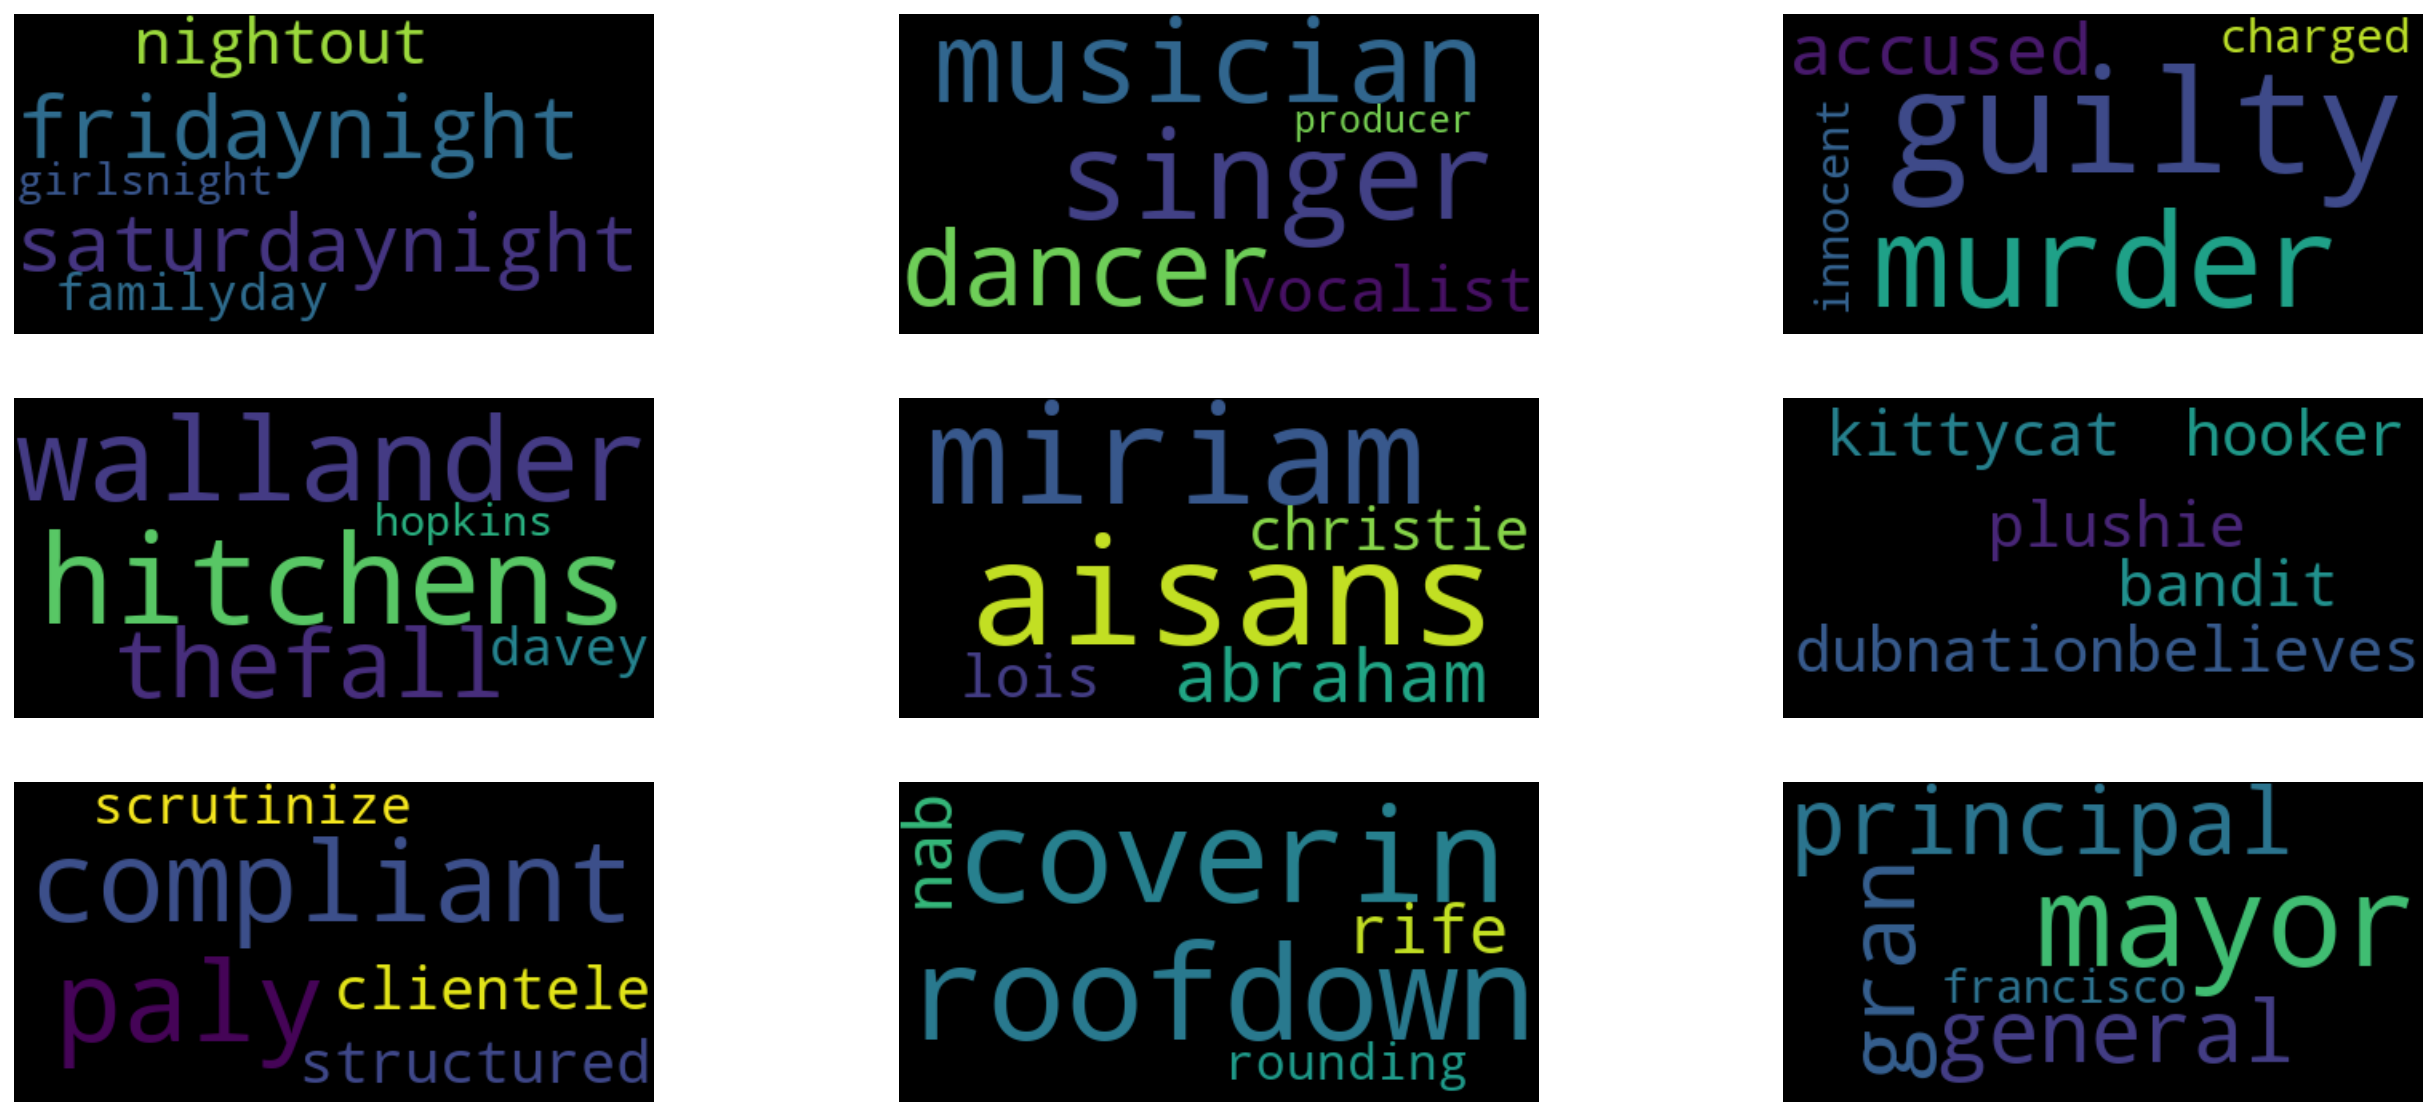

In [64]:
index = np.random.randint(1, word_number, 9)
plt.figure(figsize=(20,10))

for k in range(len(index)):
    plt.subplot(3, 3, k+1)
    
    x = index[k]
    text = ' '.join([index_word[x]] + [index_word[synonyms[x][i]] for i in range(synonyms_number-1)]) 
    wordcloud = WordCloud(stopwords=[]).generate((text))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


# Step 4 - Data Augmentation / Oversampling
We work on 1 labelled texts. We apply the following algorithm to modify a sentence :
For each word in the sentence :

Keep it with probability  p  (or if we don't have synonyms for it)
Randomly swap it with one of its synonyms with probability  1−p

In [65]:
X_pos = X[y==1]

def modify_sentence(statement, synonyms, p=0.5):
    for i in range(len(statement)):
        if np.random.random() > p:
            try:
                syns = synonyms[statement[i]]
                statement[i] = np.random.choice(syns)
            except KeyError:
                pass
    return statement

In [66]:
indexes = np.random.randint(0, X_pos.shape[0], 100000)

In [71]:
new_train_samples = []
for x in X_pos[indexes]:
    sample =  np.trim_zeros(x)
    modified = modify_sentence(sample, synonyms)
    sentence_m = ' '.join([index_word[x] for x in modified])
    new_train_samples.append(sentence_m)

In [72]:
train_samples.shape

(21414,)

In [73]:
for i in train_samples : 
    new_train_samples.append(i)

print(len(new_train_samples))

121414


In [74]:
n_texts = 100000

indexes = np.random.randint(0, X_pos.shape[0], n_texts)
X_gen = np.array([modify_sentence(x, synonyms) for x in X_pos[indexes]])
y_gen = np.ones(n_texts)


In [75]:
embed_mat.shape

(22374, 100)

In [76]:
X_gen.shape

(100000, 100)

In [77]:
aug_embed_mat = np.vstack((embed_mat,X_gen))

In [78]:
new_train_labels = np.hstack((train_labels,y_gen))
new_train_labels.shape

(121414,)

In [79]:
len(new_train_samples)

121414

In [80]:
aug_embed_mat.shape

(122374, 100)

In [81]:
embedding_dim =100
num_tokens = 122374

from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(aug_embed_mat),
    trainable=False)

In [82]:
new_train_samples  = np.array(new_train_samples)
new_train_labels   = np.array(new_train_labels)

In [83]:
updated_train_df = pd.DataFrame([new_train_samples.T,new_train_labels.T])

In [84]:
updated_train_df = updated_train_df.transpose()

In [85]:
updated_train_df[0]

0         always in thinking that definitely because but...
1         ny cunt campaign co chair unleashes on obamas ...
2         chelsea italians of assesses the asshat not th...
3                                  yeah guy damn patriarchy
4         fuck that what homophobic misogynistic misogyn...
                                ...                        
121409    waltdisneyreso should be ashamed of themselves...
121410    invited over for catch up and could not stop t...
121411    black professor makes assumptions about an ent...
121412    lgbtqhatetrumppay is total liberal trash its p...
121413    what makes people is relative we have our way ...
Name: 0, Length: 121414, dtype: object

In [86]:
x_tr, y_tr = updated_train_df[0].values, updated_train_df[1].values

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(val_samples)

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=100)
x_val_seq = pad_sequences(x_val_seq, maxlen=100)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_tr_seq, y_tr_seq)

y_pred = model.predict(x_val_seq)

print("Training Accuracy :", model.score(x_tr_seq, y_tr_seq))
print("Validation Accuracy :", model.score(x_val_seq,y_val_seq))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

(122374, 100)

In [ ]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

29372


In [ ]:
embed_mat = make_embedding_matrix(glove_embedding_index, tokenizer, size_of_vocabulary)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,100,weights=[embed_mat],input_length=100,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 122374, 100)       2937200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 122374, 128)       117248    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 3,062,769
Trainable params: 125,569
Non-trainable params: 2,937,200
_________________________________________________________________
None


In [ ]:
from keras import backend as K
x_tr_seq = K.cast_to_floatx(x_tr_seq)
y_tr = K.cast_to_floatx(y_tr)

In [ ]:
y_val = np.array(val_labels)

In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print  (" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return
metrics = Metrics()

In [ ]:
history = model.fit(np.array(x_tr_seq),np.array(y_tr),batch_size=128,epochs=2,validation_data=(np.array(x_val_seq),np.array(y_val)),verbose=1,callbacks=[es,mc])

In [ ]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq,y_val, batch_size=128)
print(val_acc)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

In [ ]:
test_samples = test['tweet'].progress_apply(lambda x: tweet_cleaner(x)).values

100%|██████████| 17197/17197 [00:04<00:00, 3952.13it/s]


In [ ]:
test_seq = tokenizer.texts_to_sequences(test_samples)
test_seq = pad_sequences(test_seq, maxlen=100)

In [ ]:
tweet_preds = model.predict(test_seq, batch_size=128)
print(tweet_preds)

[[0.99999964]
 [1.        ]
 [1.        ]
 ...
 [1.        ]
 [1.        ]
 [1.        ]]


In [ ]:
probabilities = np.where(tweet_preds < 1, 0, 1)
probabilities

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
predictions = pd.DataFrame(probabilities, columns=['predictions']).to_csv('prediction.csv')


In [ ]:
final = pd.read_csv('prediction.csv')

In [ ]:
final['id'] = np.arange(31963,49160)

In [ ]:
final.predictions.value_counts()

1    14551
0     2646
Name: predictions, dtype: int64

In [ ]:
final = pd.DataFrame(final.values[:, 1:3]).to_csv('predictions.csv')